# ОИАД. Лабораторная работа №3

https://www.kaggle.com/datasets/mosapabdelghany/medical-insurance-cost-dataset?resource=download

## 1. Подготовка данных
1. проверить наличие пропусков и выбросов
2. привести категориальные признаки к числовым
3. вычислить парные корреляции признаков

## 2. Многомерная линейная регрессия
Построить модель линейной регрессии и подобрать параметры:
1. аналитически (реализовать самому)
2. численно, с помощью методов градиентного спуска (реализовать самому)

## 3. Добавление регуляризации
Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:
1. аналитически
2. численно

## 4. Оценка обобщающей способности
Сравнить между собой модели на тестовых данных по среднему квадрату ошибки:
1. константную - прогноз средним значением
2. из пункта 2
3. из пункта 3

## 1. Подготовка данных

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [23]:
df = pd.read_csv('../datasets/insurance.csv')
print(df.head())
print(df.info())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


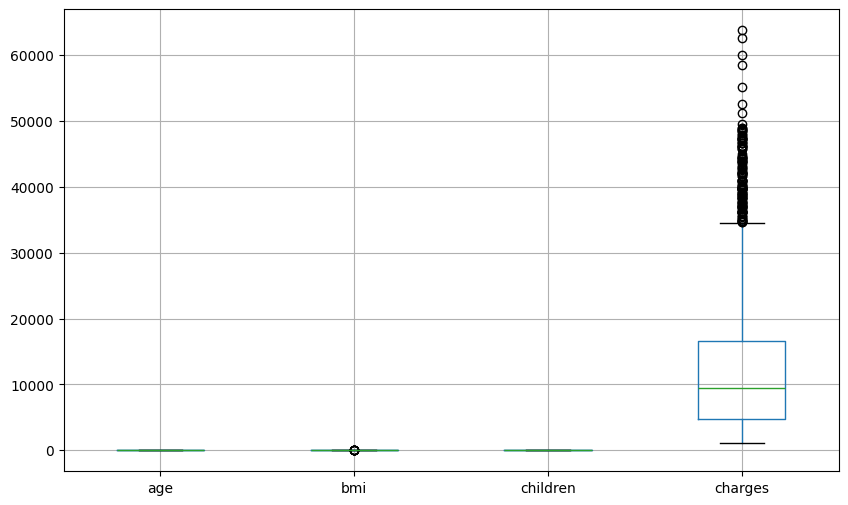

Index(['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')


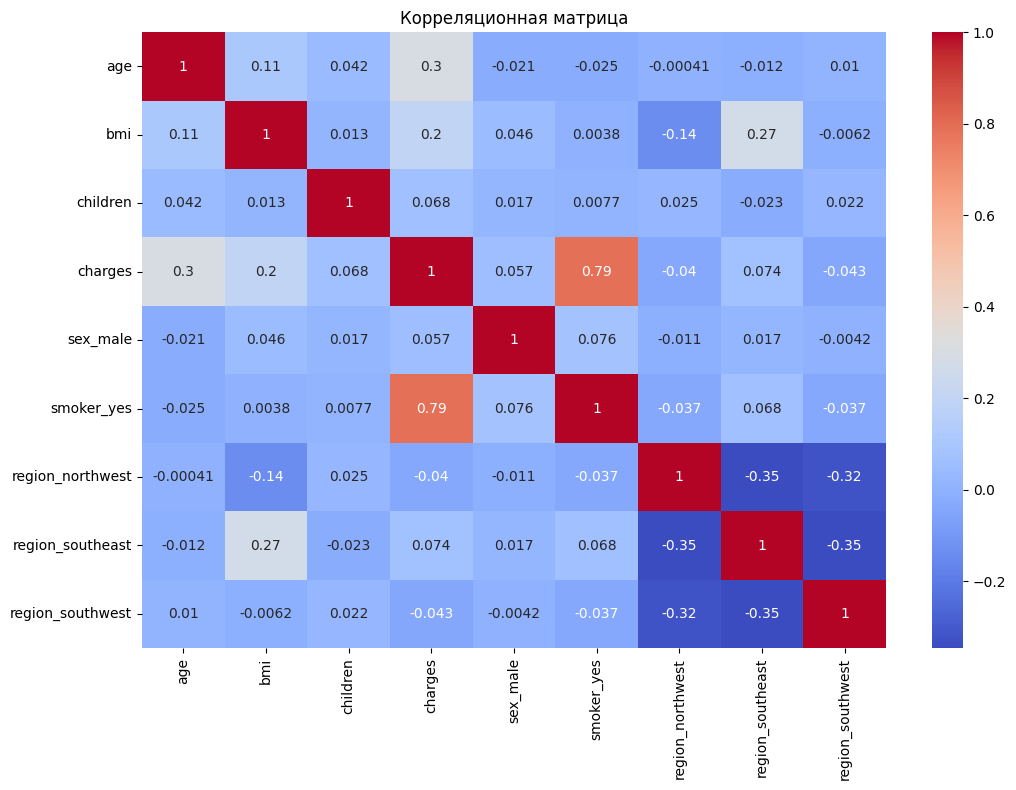

In [24]:
# Проверка пропусков
print(df.isnull().sum())

# Проверка выбросов
num_cols = ['age', 'bmi', 'children', 'charges']
df[num_cols].boxplot(figsize=(10, 6))
plt.show()

# Приведение категориальных признаков к числовым
df = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
print(df.columns)

#Парные корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()


## 2. Многомерная линейная регрессия

In [25]:
X = df.drop('charges', axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_bias = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_bias = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

In [26]:
# Аналитическое решение (нормальное уравнение)
w_analytic = np.linalg.inv(X_train_bias.T @ X_train_bias) @ X_train_bias.T @ y_train

y_pred_analytic = X_test_bias @ w_analytic
mse_analytic = mean_squared_error(y_test, y_pred_analytic)
print("MSE (аналитически):", mse_analytic)

MSE (аналитически): 33596915.85136148


In [27]:
# Численное решение (градиентный спуск)
def gradient_descent(X, y, lr=0.01, epochs=1000):
    m, n = X.shape
    w = np.random.randn(n)
    for _ in range(epochs):
        y_pred = X @ w
        error = y_pred - y
        grad = (2/m) * X.T @ error
        w -= lr * grad
    return w

w_gd = gradient_descent(X_train_bias, y_train, lr=0.01, epochs=5000)
y_pred_gd = X_test_bias @ w_gd
mse_gd = mean_squared_error(y_test, y_pred_gd)
print("MSE (град. спуск):", mse_gd)

MSE (град. спуск): 33596915.85136143


## 3. Добавление регуляризации (Ridge)

In [28]:
# Аналитическое решение (Ridge)
def ridge_analytic(X, y, lam=1.0):
    I = np.eye(X.shape[1])
    I[0, 0] = 0  # не регуляризуем bias
    return np.linalg.inv(X.T @ X + lam * I) @ X.T @ y

w_ridge_analytic = ridge_analytic(X_train_bias, y_train, lam=10.0)
y_pred_ridge_analytic = X_test_bias @ w_ridge_analytic
mse_ridge_analytic = mean_squared_error(y_test, y_pred_ridge_analytic)
print("MSE (Ridge analyt.):", mse_ridge_analytic)

MSE (Ridge analyt.): 33685862.85657277


In [29]:
# Численное решение (градиентный спуск с регуляризацией)
def ridge_gd(X, y, lam=1.0, lr=0.01, epochs=5000):
    m, n = X.shape
    w = np.random.randn(n)
    for _ in range(epochs):
        y_pred = X @ w
        error = y_pred - y
        grad = (2/m) * X.T @ error + 2 * lam * w
        grad[0] = (2/m) * X[:, 0] @ error  # bias без регуляризации
        w -= lr * grad
    return w

w_ridge_gd = ridge_gd(X_train_bias, y_train, lam=10.0, lr=0.01, epochs=5000)
y_pred_ridge_gd = X_test_bias @ w_ridge_gd
mse_ridge_gd = mean_squared_error(y_test, y_pred_ridge_gd)
print("MSE (Ridge GD):", mse_ridge_gd)

MSE (Ridge GD): 134805290.94206688


## 4. Оценка обобщающей способности

In [30]:
# Константная модель (среднее)
y_mean = np.mean(y_train)
y_pred_const = np.full_like(y_test, y_mean)
mse_const = mean_squared_error(y_test, y_pred_const)
print("MSE (константа):", mse_const)

# Сравнение всех моделей
results = {
    "Константа": mse_const,
    "Лин. регр. (аналит.)": mse_analytic,
    "Лин. регр. (GD)": mse_gd,
    "Ridge (аналит.)": mse_ridge_analytic,
    "Ridge (GD)": mse_ridge_gd
}

for name, mse in results.items():
    print(f"{name}: {mse:.2f}")

MSE (константа): 155391443.68461317
Константа: 155391443.68
Лин. регр. (аналит.): 33596915.85
Лин. регр. (GD): 33596915.85
Ridge (аналит.): 33685862.86
Ridge (GD): 134805290.94


## Вывод по результатам моделирования

Сравнивая среднеквадратичные ошибки (MSE) на тестовых данных, можно сделать следующие выводы:

- **Константная модель**, предсказывающая среднее значение целевой переменной, показывает **наихудший результат** (MSE ≈ 155 млн), что подтверждает необходимость использования более сложных моделей.
  
- **Многомерная линейная регрессия**, обученная как аналитически (через нормальное уравнение), так и численно (градиентным спуском), демонстрирует **значительно лучшее качество** (MSE ≈ 33.6 млн). Оба подхода дали **практически идентичные результаты**, что свидетельствует о корректной реализации градиентного спуска.

- **Ridge-регрессия (аналитическая)** показала **незначительное ухудшение** по сравнению с обычной линейной регрессией (MSE ≈ 33.7 млн), что может говорить о том, что:
  - либо регуляризация была избыточной (слишком большое λ),
  - либо в данных мало мультиколлинеарности, и регуляризация не даёт преимущества.

- **Ridge-регрессия (численная)** показала **резко худшее качество** (MSE ≈ 134.8 млн), что указывает на **ошибку в реализации градиентного спуска с регуляризацией** — вероятно, неправильно обработан свободный член (bias), слишком большой шаг обучения или недостаточное число итераций.

### Рекомендации:
- Проверить корректность численной реализации Ridge-регрессии (особенно масштабирование и обработку bias).
- Подобрать оптимальный коэффициент регуляризации λ с помощью кросс-валидации.
- В текущих условиях **наилучшей моделью** является обычная **линейная регрессия**, обученная аналитически или градиентным спуском.